In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from matplotlib import font_manager, rc
import platform

if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
    
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')
    
plt.style.use('ggplot')
import datetime
np.random.seed(0)
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p
import time
from tqdm.notebook import tqdm

In [2]:
## 제공 데이터
train = pd.read_csv('train_after_processing_weatheropt3.csv',header = 0,index_col=0, encoding='cp949') 
test = pd.read_csv('test_after_processing_weatheropt3.csv',header = 0,index_col=0, encoding='cp949')
test_submit = pd.read_excel('test_submit.xlsx',header=1)

In [3]:
w2v_train = pd.read_csv('w2v_tr_feature.csv')
w2v_test = pd.read_csv('w2v_te_feature.csv')

w2v_df=pd.concat([w2v_train,w2v_test])

# 못다한 전처리

* 시청률 drop, 취급액 0인 row drop, 브랜드 fill na

In [5]:
train = train.drop(['시청률'],axis=1)

train['취급액'] = train['취급액'].apply(lambda x: np.NAN if x==0 else x)

train['브랜드'] = train['브랜드'].fillna('없음')

train = train.dropna()

target = np.log1p(train['취급액'])

* prime_time 추가

In [6]:
train['판매량'] = train['취급액']/train['판매단가']
for i in range(24):
    if i == 0:
        t = train.groupby(['상품군','hour'])['판매량'].agg([('판매량_mean','mean')]).reset_index()
        v = t.query('hour == @i').sort_values('판매량_mean',ascending = False).reset_index().drop(columns='index')
        v['판매량_mean'] = [i for i in range(len(v),0,-1)]
    else:
        t = train.groupby(['상품군','hour'])['판매량'].agg([('판매량_mean','mean')]).reset_index()
        a = t.query('hour == @i').sort_values('판매량_mean',ascending = False).reset_index().drop(columns='index')
        a['판매량_mean'] = [i for i in range(len(a),0,-1)]
        
        v = pd.concat([v,a],axis=0)
    v = v.reset_index().drop('index',axis=1)


* prime_time 2 추가

In [7]:
t = train.groupby(['대','hour'])['판매량'].mean().reset_index()
t = t.sort_values(['대','판매량'])
t['순위'] = t.groupby(['대'])['판매량'].rank(method='max',ascending=True)

t= t.drop('판매량',axis=1)

t['순위'] = t['순위'].astype('int8')

train = train.drop('판매량',axis=1)

* df + prime_time1,2 + w2v feature

In [8]:
df = pd.concat([train,test])

df = pd.merge(df,v,left_on=['hour','상품군'],right_on = ['hour','상품군'],how='left')

df = pd.merge(df,t, left_on = ['대','hour'],right_on=['대','hour'],how='left')

df['판매량_mean'] = df['판매량_mean'].fillna(5.0)

df['순위'] = df['순위'].fillna(5.0)

df = pd.concat([df.reset_index(),w2v_df.reset_index()],axis=1).drop('index',axis=1)

* feature_type 변경

In [9]:
df['상품코드'] = df['상품코드'].apply(lambda x:str(x))
df['마더코드'] = df['마더코드'].apply(lambda x:str(x))
df['month'] = df['month'].apply(lambda x:str(int(x)))
df['day'] = df['day'].apply(lambda x:str(int(x)))
df['hour'] = df['hour'].apply(lambda x:str(int(x)))
df['공휴일'] = df['공휴일'].apply(lambda x:str(int(x)))
df['강수여부'] = np.where(df['강수량_mean']==0,False,True)
df['강수여부'] = df['강수여부'].apply(lambda x:str(int(x)))
df['minute'] = df['minute'].apply(lambda x:float(x))

In [10]:
df = df.drop(['방송일시','상품명','취급액','일사_mean','일사_min','일사_max'],axis=1)

* feature의 box-cox변환

In [11]:
features_index = df.dtypes[(df.dtypes=='float') | (df.dtypes=='int64')].index

skew_features = df[features_index].apply(lambda x: skew(x))

skew_features_over1_5 = skew_features[np.abs(skew_features) > 1.03]

for i in skew_features_over1_5.index:
    try:
        _,optimal_lambda = stats.boxcox(df[i])
        df[i] = boxcox1p(df[i],np.round(optimal_lambda,3))
        print(i,'의 최적의 lambda:',optimal_lambda,'\n')
    except:
        df[i] = boxcox1p(df[i],0.15)
        
        print('0인 row가 존재하여 0.15로 box-cox 변환',i,'\n')

판매단가 의 최적의 lambda: -0.38060338377774783 

0인 row가 존재하여 0.15로 box-cox 변환 item_w_mean 

0인 row가 존재하여 0.15로 box-cox 변환 풍향_min 

풍향_max 의 최적의 lambda: 9.311679616799488 

0인 row가 존재하여 0.15로 box-cox 변환 풍속_min 

풍속_max 의 최적의 lambda: 0.10831167082982646 

0인 row가 존재하여 0.15로 box-cox 변환 강수량_mean 

0인 row가 존재하여 0.15로 box-cox 변환 강수량_max 

0인 row가 존재하여 0.15로 box-cox 변환 강수여부_count 

pm10 의 최적의 lambda: -0.06788059479474945 

pm25 의 최적의 lambda: 0.023865461524578222 

0인 row가 존재하여 0.15로 box-cox 변환 w2v_27 

0인 row가 존재하여 0.15로 box-cox 변환 w2v_31 

0인 row가 존재하여 0.15로 box-cox 변환 w2v_95 

0인 row가 존재하여 0.15로 box-cox 변환 w2v_101 

0인 row가 존재하여 0.15로 box-cox 변환 w2v_107 

w2v_121 의 최적의 lambda: -0.025287520268332062 

0인 row가 존재하여 0.15로 box-cox 변환 w2v_123 

0인 row가 존재하여 0.15로 box-cox 변환 w2v_133 

0인 row가 존재하여 0.15로 box-cox 변환 w2v_134 

0인 row가 존재하여 0.15로 box-cox 변환 w2v_135 

0인 row가 존재하여 0.15로 box-cox 변환 w2v_139 

0인 row가 존재하여 0.15로 box-cox 변환 w2v_173 

0인 row가 존재하여 0.15로 box-cox 변환 w2v_186 

0인 row가 존재하여 0.15로 bo

* category 형으로 전환

In [12]:
for i in df.select_dtypes(include=['object']).columns:
    df[i] = df[i].astype('category').cat.codes

* feature_scaling

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_columns = df.select_dtypes(include=['float']).columns
df_scaled = scaler.fit_transform(df.select_dtypes(include=['float']))

In [14]:
df = df.drop(scaled_columns,axis=1)

In [15]:
df_scaled = pd.DataFrame(df_scaled,columns=scaled_columns,index=df.index)

In [16]:
df = pd.concat([df,df_scaled],axis=1)

# pca

In [17]:
from sklearn.decomposition import PCA
def pca(t_list,opt_num=0):
    
    global df
    print('pca전 df의 shape:',df.shape)
    for t in  t_list:
        print('\n',t,'pca 시작')
        
        
        if t =="item_":
            opt_num = 1
            
        col_list = []   
        for i in map(str,df.columns):
            if t in i:
                col_list.append(i)
                
        
        
        a = list(df.columns).index(col_list[opt_num])

        b = list(df.columns).index(col_list[-1]) + 1

        df_pca = df.iloc[:,a:b]

        print('pca 이전 shape',df_pca.shape)

        

        max_d = num_d = df_pca.shape[1] 

        pca = PCA(n_components=max_d, random_state=0).fit(df_pca)
        cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
        num_d = np.argmax(cumsum >= 0.99) + 1             # 분산의 설명량이 99%이상 되는 차원의 수
        if num_d == 1: num_d = max_d
        pca = PCA(n_components=num_d, random_state=0).fit_transform(df_pca)
        
        print('pca 이후 shape',pd.DataFrame(pca).shape)

        df = df.drop(col_list,axis=1)

        df = pd.concat([df.reset_index(),pd.DataFrame(pca)],axis=1).set_index('index')
    print('\n','pca후 df의 shape:',df.shape)

In [18]:
t = ['w2v_'] 
pca(t)

pca전 df의 shape: (38095, 646)

 w2v_ pca 시작
pca 이전 shape (38095, 600)
pca 이후 shape (38095, 59)

 pca후 df의 shape: (38095, 105)


# train, test 분리

In [19]:
train = df.iloc[:train.shape[0]]
test = df.iloc[train.shape[0]:]
train_col = train.columns

# kmeans featurerizer

In [20]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

class KMeansFeaturizer:
    """Transforms numeric data into k-means cluster memberships.
    
    This transformer runs k-means on the input data and converts each data point
    into the id of the closest cluster. If a target variable is present, it is 
    scaled and included as input to k-means in order to derive clusters that
    obey the classification boundary as well as group similar points together.

    Parameters
    ----------
    k: integer, optional, default 100
        The number of clusters to group data into.

    target_scale: float, [0, infty], optional, default 5.0
        The scaling factor for the target variable. Set this to zero to ignore
        the target. For classification problems, larger `target_scale` values 
        will produce clusters that better respect the class boundary.

    random_state : integer or numpy.RandomState, optional
        This is passed to k-means as the generator used to initialize the 
        kmeans centers. If an integer is given, it fixes the seed. Defaults to 
        the global numpy random number generator.

    Attributes
    ----------
    cluster_centers_ : array, [k, n_features]
        Coordinates of cluster centers. n_features does count the target column.
    """

    def __init__(self, k=100, target_scale=5, random_state=None):
        self.k = k
        self.target_scale = target_scale
        self.random_state = random_state
        self.cluster_encoder = OneHotEncoder().fit(np.array(range(k)).reshape(-1,1))
        
    def fit(self, X, y=None):
        """Runs k-means on the input data and find centroids.

        If no target is given (`y` is None) then run vanilla k-means on input
        `X`. 

        If target `y` is given, then include the target (weighted by 
        `target_scale`) as an extra dimension for k-means clustering. In this 
        case, run k-means twice, first with the target, then an extra iteration
        without.

        After fitting, the attribute `cluster_centers_` are set to the k-means
        centroids in the input space represented by `X`.

        Parameters
        ----------
        X : array-like or sparse matrix, shape=(n_data_points, n_features)

        y : vector of length n_data_points, optional, default None
            If provided, will be weighted with `target_scale` and included in 
            k-means clustering as hint.
        """
        if y is None:
            # No target variable, just do plain k-means
            km_model = KMeans(n_clusters=self.k, n_init=20, random_state=self.random_state)
            km_model.fit(X)

            self.km_model_ = km_model
            self.cluster_centers_ = km_model.cluster_centers_
            return self

        # There is target information. Apply appropriate scaling and include
        # into input data to k-means            
        data_with_target = np.hstack((X, y[:,np.newaxis]*self.target_scale))

        # Build a pre-training k-means model on data and target
        km_model_pretrain = KMeans(n_clusters=self.k, n_init=20, random_state=self.random_state)
        km_model_pretrain.fit(data_with_target)

        # Run k-means a second time to get the clusters in the original space
        # without target info. Initialize using centroids found in pre-training.
        # Go through a single iteration of cluster assignment and centroid 
        # recomputation.
        km_model = KMeans(n_clusters=self.k, 
                          init=km_model_pretrain.cluster_centers_[:,:data_with_target.shape[1]-1], 
                          n_init=1, max_iter=1)
        km_model.fit(X)
        
        self.km_model = km_model
        self.cluster_centers_ = km_model.cluster_centers_
        return self
        
    def transform(self, X, y=None):
        """Outputs the closest cluster id for each input data point.

        Parameters
        ----------
        X : array-like or sparse matrix, shape=(n_data_points, n_features)

        y : vector of length n_data_points, optional, default None
            Target vector is ignored even if provided.

        Returns
        -------
        cluster_ids : array, shape[n_data_points,1]
        """
        clusters = self.km_model.predict(X)
        onehot = self.cluster_encoder.transform(clusters.reshape(-1,1)).toarray()
        max_col = onehot.shape[1]
        pca = PCA(n_components=max_col, random_state=0).fit(onehot)
        cumsum = np.cumsum(pca.explained_variance_ratio_)
        num_col = np.argmax(cumsum >= 0.99) + 1
        if num_col == 1: num_col = max_col
        pca = PCA(n_components = num_col, random_state=0).fit_transform(onehot)
        return pd.DataFrame(pca)
    
    def fit_transform(self, X, y=None):
        """Runs fit followed by transform.
        """
        self.fit(X, y)
        return self.transform(X, y)

In [21]:
kmf_hint = KMeansFeaturizer(k=10, target_scale=5, random_state=0).fit(train, target)
#kmf_no_hint = KMeansFeaturizer(k=30, target_scale=0, random_state=0).fit(train_x, y_train)

# Generate k-means clustering features
training_cluster_features = kmf_hint.transform(train)
test_cluster_features = kmf_hint.transform(test)
training_cluster_features.index = train.index
test_cluster_features.index=test.index
# Augment existing features with the k-means clustering features
train_k = pd.concat([train, training_cluster_features], axis=1)
test_k = pd.concat([test, test_cluster_features], axis=1)

print(train_k.shape)
print(test_k.shape)

(35379, 114)
(2716, 114)


In [22]:
train_columns = train_k.columns
test_columns = test_k.columns

In [23]:
train_k.columns = [i for i in range(len(train_k.columns))]
test_k.columns = [i for i in range(len(test_k.columns))]

# 모델링

In [24]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from xgboost import XGBRegressor 
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor

In [25]:
X_train, X_test, y_train, y_test = train_test_split(train_k,target, test_size=.2, random_state = 1)

* cv

In [26]:
from sklearn.metrics import make_scorer

def mape(actual,pred): 
    pred = np.expm1(pred)
    actual = np.expm1(actual)
    actual, pred = np.array(actual), np.array(pred)
    pred = np.nan_to_num(pred, copy=False)
    mape = np.mean(np.abs((actual - pred) / actual)) * 100
    return mape
mape_score = make_scorer(mape)



xgb_reg = XGBRegressor(n_jobs=-1,random_state=0)
rf_reg = RandomForestRegressor(n_jobs=-1, random_state=0)
lgbm_reg = LGBMRegressor(n_jobs=-1,random_state=0)

models=[xgb_reg, lgbm_reg, rf_reg]

for model in models:
    
    k_fold = KFold(n_splits=5)
    score_rf = cross_val_score(model, X_train, y_train, cv=k_fold, scoring = mape_score,n_jobs=-1)
    score_rf_mean = score_rf.mean()
    print(model.__class__.__name__,'의 5 cv score:' ,score_rf_mean) 

XGBRegressor 의 5 cv score: 44.05131543884411
LGBMRegressor 의 5 cv score: 51.74932325569703
RandomForestRegressor 의 5 cv score: 48.79285276444244


* tuning

In [27]:
# regs = [  

# #     (   LGBMRegressor(random_state=0, n_jobs=-1,num_iterations =1000,metric='mape'),
# #          {
# #     'num_leaves' : [30, 50, 70, 100],
# #     'learning_rate': [0.1,0.01,0.05,0.001],
# #     'n_estimators': [ 100, 200, 500], 
# #     'max_depth': [3,5,10,8]}
# #     )
# #      (   XGBRegressor(random_state=0, n_jobs=-1),
# #     {'learning_rate': [1,0.1,0.01,0.001],
# #     'n_estimators': [50, 100, 200, 500, 1000],
# #     'max_depth' : [1,3,5,10,50]}
# #     )
# ]

# from sklearn.metrics import make_scorer

# def mape(actual,pred): 
#     pred = np.expm1(pred)
#     actual = np.expm1(actual)
#     actual, pred = np.array(actual), np.array(pred)
#     pred = np.nan_to_num(pred, copy=False)
#     mape = np.mean(np.abs((actual - pred) / actual)) * 100
#     return -mape
# mape_score = make_scorer(mape)

# reg_tuned = []
# for reg, param_grid in tqdm(regs):
#     start = time.time()
#     rand_search = RandomizedSearchCV(reg, param_grid, scoring=mape_score,
#                                      cv=3,  n_jobs=-1)
#     rand_search.fit(X_train, y_train)
#     reg_name = type(reg).__name__
#     mape_score1 = get_mape(rand_search)
#     print('{:30s} {:30f} {:.1f}'.format(reg_name, mape_score1, time.time() - start))
#     reg_tuned.append((reg_name, rand_search, mape_score))

### best_estimator training

In [28]:
def get_mape(model): 
    y_pred = model.predict(X_test)
    y_pred = np.expm1(y_pred)
    y_test_exp = np.expm1(y_test)
    y_test_exp, y_pred = np.array(y_test_exp), np.array(y_pred)
    mape = np.mean(np.abs((y_test_exp - y_pred) / y_test_exp)) * 100
    print('{0} 의 mape: {1}'.format(model.__class__.__name__,np.round(mape, 3)))
    return mape

In [29]:
rf_reg = RandomForestRegressor(n_jobs=-1, random_state=0)
rf_reg.fit(X_train,y_train)

get_mape(rf_reg)

RandomForestRegressor 의 mape: 44.238


44.23780276480208

In [30]:
xgb_reg = XGBRegressor(learning_rate=0.1,
                             eta = 0.01,
                             max_depth = 9,
                             n_estimators=500,
                            gamma = 0.05) 
xgb_reg.fit(X_train,y_train)

get_mape(xgb_reg)

XGBRegressor 의 mape: 36.342


36.342350773372935

In [31]:
lgbm_reg = LGBMRegressor(max_depth = 10,
                        n_estimators=100,
                        num_leaves=50,
                        num_iterations=1000,
                        metric='mape') 
lgbm_reg.fit(X_train,y_train)

get_mape(lgbm_reg)

LGBMRegressor 의 mape: 37.701


37.70072356131398

* feature_importance

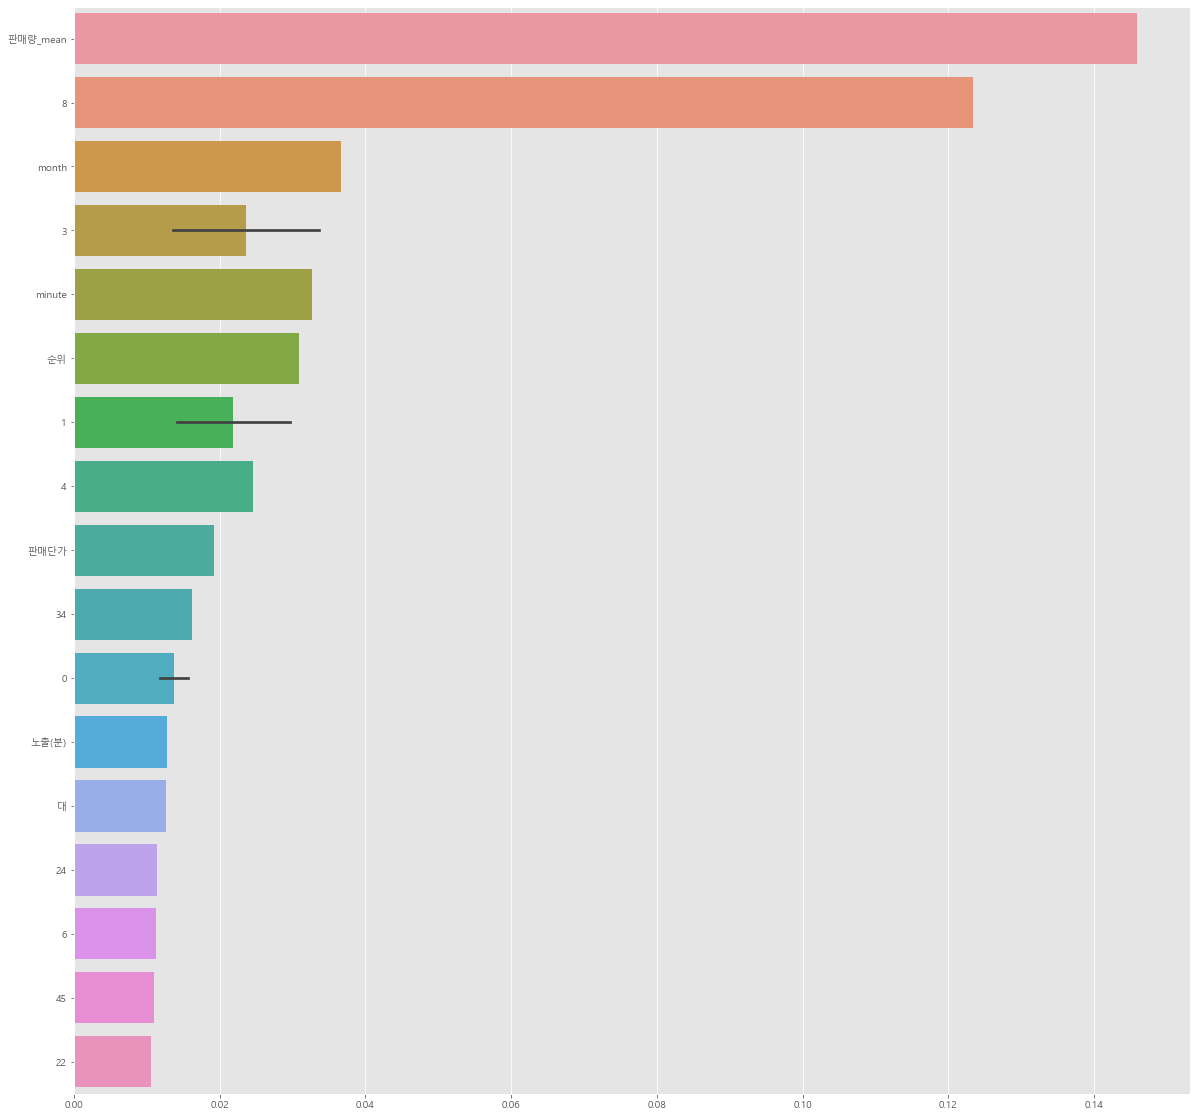

In [32]:
xgb_imp = pd.Series(xgb_reg.feature_importances_,index=train_columns).sort_values(ascending=False)[0:20]
plt.figure(figsize=(20,20))
sns.barplot(x=xgb_imp.values, y = xgb_imp.index)

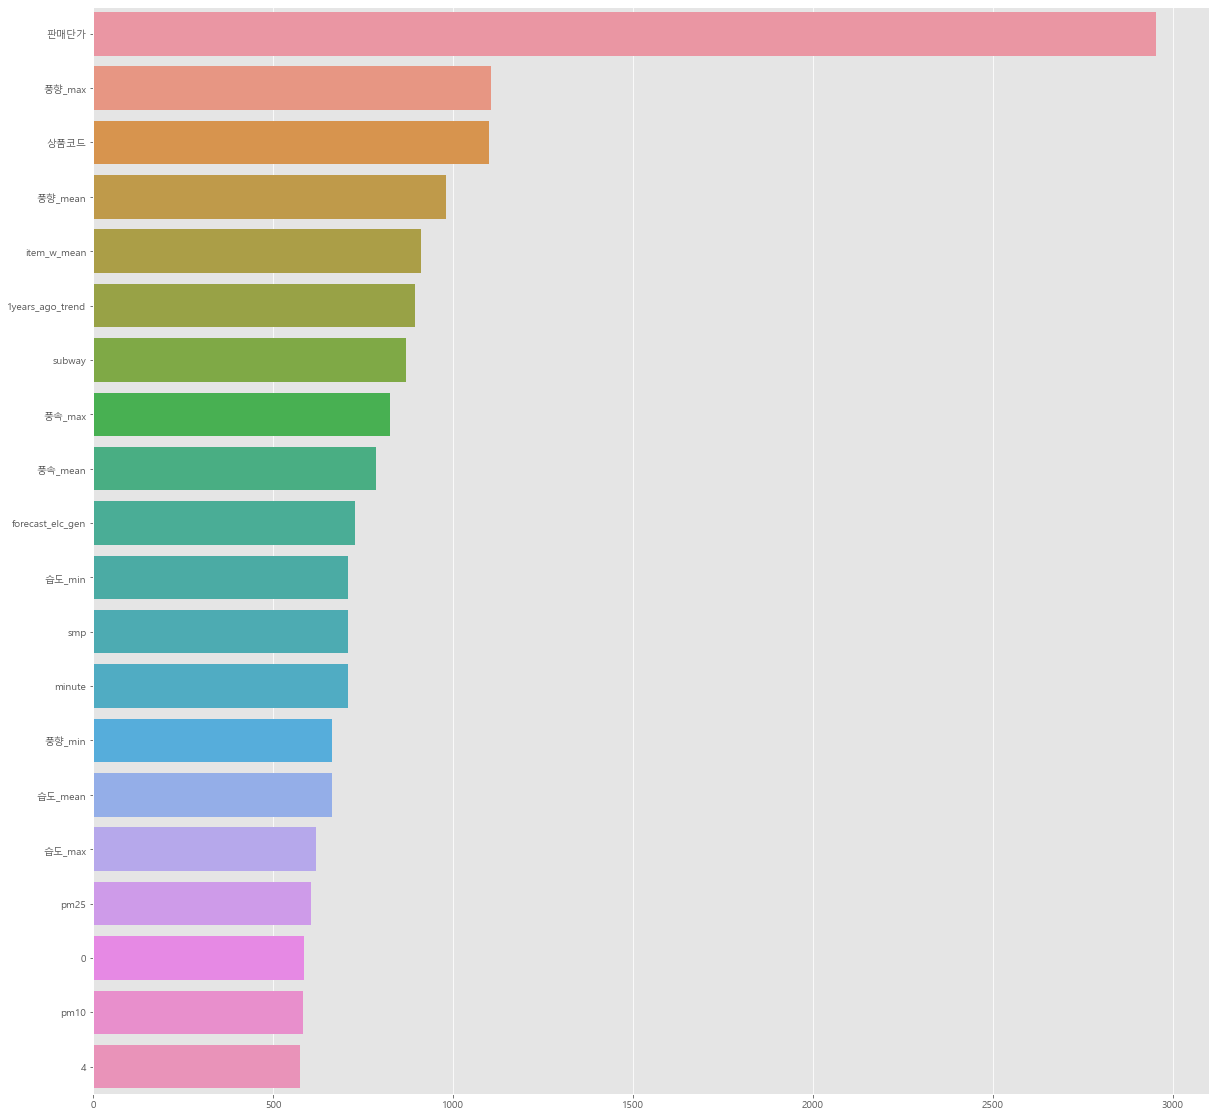

In [33]:
lgbm_imp = pd.Series(lgbm_reg.feature_importances_,index=train_columns).sort_values(ascending=False)[0:20]
plt.figure(figsize=(20,20))
sns.barplot(x=lgbm_imp.values, y = lgbm_imp.index)


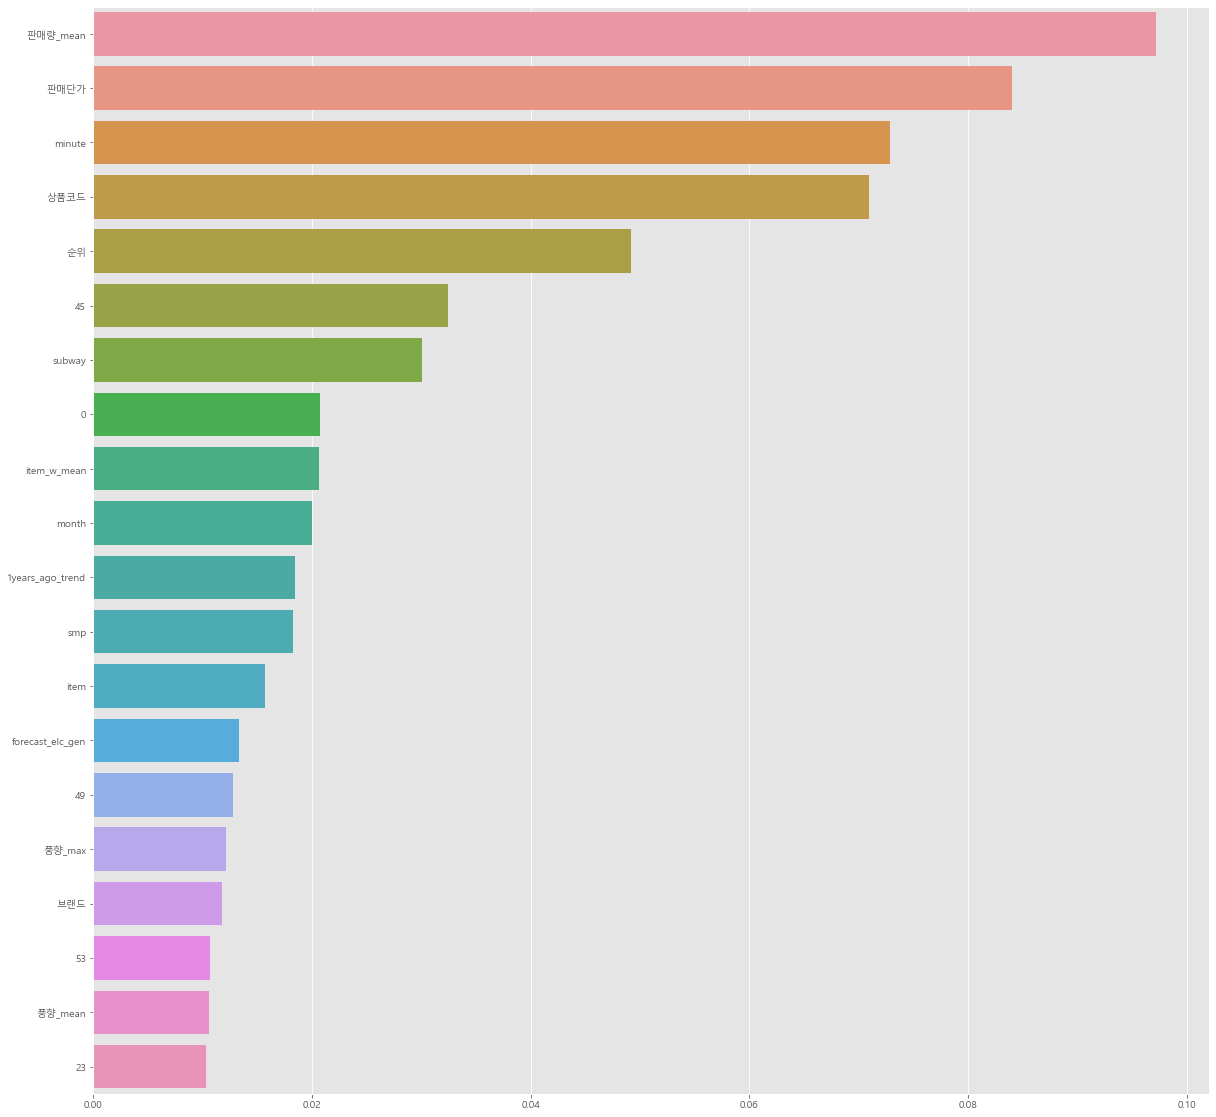

In [34]:
rf_imp = pd.Series(rf_reg.feature_importances_,index=train_columns).sort_values(ascending=False)[0:20]
plt.figure(figsize=(20,20))
sns.barplot(x=rf_imp.values, y = rf_imp.index)

# submit

In [35]:
mu_sub = test_submit[test_submit['상품군'] == '무형']

In [36]:
test_submit = test_submit.drop(mu_sub.index)

In [37]:
sub = (np.expm1(xgb_reg.predict(test_k)) + np.expm1(lgbm_reg.predict(test_k)))/2

In [38]:
test_submit['취급액'] = sub

In [39]:
test_submit = pd.concat([test_submit,mu_sub]).sort_index()

In [40]:
test_submit

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
0,2020-06-01 06:20:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,1.595470e+07
1,2020-06-01 06:40:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,2.233095e+07
2,2020-06-01 07:00:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,1.185101e+07
3,2020-06-01 07:20:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,2.304725e+07
4,2020-06-01 07:40:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,3.247050e+07
...,...,...,...,...,...,...,...,...
2886,2020-07-01 00:20:00,20.000000,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,NaN
2887,2020-07-01 00:40:00,20.000000,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,NaN
2888,2020-07-01 01:00:00,20.000000,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,NaN
2889,2020-07-01 01:20:00,20.000000,100261,200875,아놀드파마 티셔츠레깅스세트,의류,69900,7.675326e+06


In [41]:
test_submit.to_csv('submit.csv',index=None,encoding='cp949')